In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from astropy.io import ascii, fits
from astropy.io.fits import getdata

import pydis

import glob

/Users/cbrasseur/anaconda/envs/gphoton/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/cbrasseur/anaconda/envs/gphoton/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
## CHANGE THIS FOR WHATEVER YOUR PATH IS ##
disDir = "/Users/cbrasseur/Documents/ObsAstro/APO/Q4JH03/UT161120/DIS/"

In [16]:
# making a list of the flat fields
with open (disDir + 'rflat.lis','w') as FLATFLE:
    FLATFLE.write('\n'.join(glob.glob(disDir + "*flat.0*r.fits")))

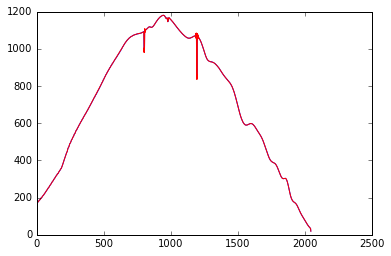

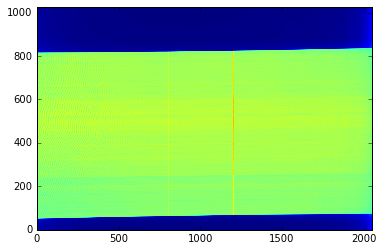

In [20]:
bias = np.zeros((1028, 2048)) # apparently we didn't take any bias frames??? wtf????

flat, fmask_out = pydis.flatcombine(disDir + 'rflat.lis', bias, trim=True, mode='spline', 
                                   response=True, display=True, output=disDir+'FLAT.fits')

In [22]:
HeRed = disDir + 'He.0007r.fits'
ArRed = disDir + 'Ar.0008r.fits'
NeRed = disDir + 'Ne.0009r.fits'

Running HeNeAr_fit function on file /Users/cbrasseur/Documents/ObsAstro/APO/Q4JH03/UT161120/DIS/Ne.0009r.fits

Using INTERACTIVE HeNeAr_fit mode:
1) Click on HeNeAr lines in plot window
2) Enter corresponding wavelength in terminal and press <return>
   If mis-click or unsure, just press leave blank and press <return>
3) To delete an entry, click on label, enter "d" in terminal, press <return>
4) Close plot window when finished


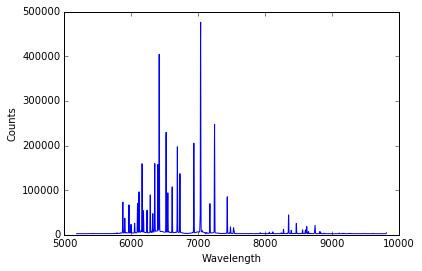

> You have identified 0 lines


TypeError: expected non-empty vector for x

In [26]:
# To really work this can't be done in a jupyter notebook unfortunately
wfit = pydis.HeNeAr_fit(NeRed, trim=True, fmask=fmask_out,
                          interac=True, mode='poly', fit_order=5)


In [27]:
wfit = np.loadtxt(disDir+"WFIT.txt")

In [35]:
# Read in and reduce the flux standard star
stdspec = disDir + 'Feige34_90.0002r.fits'
img = pydis.OpenImg(stdspec, trim=True)
stdraw = img.data
stdexptime = img.exptime
stdairmass = img.airmass
stddata= ((stdraw - bias) / flat) / stdexptime

In [36]:
# reduce the science image

# the science image file name
spec = disDir + 'Quasar1_15.0003r.fits'

# open the image, get the data and a couple important numbers
img = pydis.OpenImg(spec, trim=True)
raw = img.data
exptime = img.exptime
airmass = img.airmass

# remove bias and flat, divide by exptime
data = ((raw - bias) / flat) / exptime


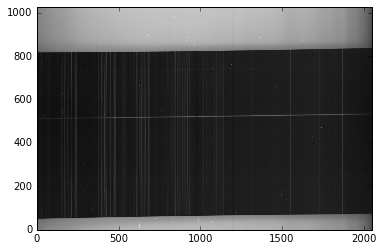

In [39]:
plt.figure()
plt.imshow(np.log10(data), origin='lower',aspect='auto',cmap=matplotlib.cm.Greys_r)
plt.show()

Tracing Aperture using nsteps=7


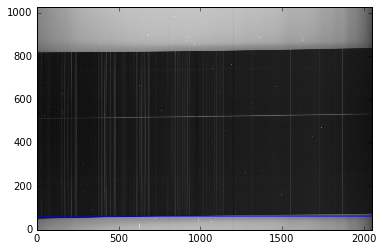

> Trace gaussian width = 3.22982981281 pixels


In [43]:
# trace the science image
trace = pydis.ap_trace(data, fmask=fmask_out, nsteps=7, interac=False, display=True)

## Obviously it is not finding the trace properly, so having to move to the shell so can do with interaction

In [46]:
trace = np.loadtxt(disDir + 'Quasar1_15.0003r.TRACE.txt')

Tracing Aperture using nsteps=7


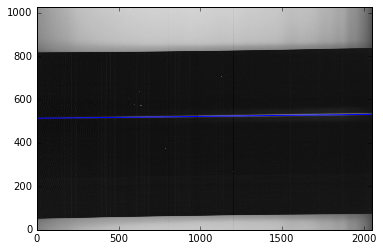

> Trace gaussian width = 5.12741907172 pixels


In [45]:
stdtrace = pydis.ap_trace(stddata, fmask=fmask_out, nsteps=7, interac=False, display=True)
# this one worked...

In [48]:
ext_spec, sky, fluxerr = pydis.ap_extract(data, trace, apwidth=5,skysep=1,
                                    skywidth=7, skydeg=0)
ext_std, stdsky, stderr = pydis.ap_extract(stddata, stdtrace, apwidth=5,
                                     skysep=1, skywidth=7, skydeg=0)

In [50]:
# subtract the sky from the 1-d spectrum
flux_red = (ext_spec - sky) # the reduced object
flux_std = (ext_std - stdsky) # the reduced flux standard

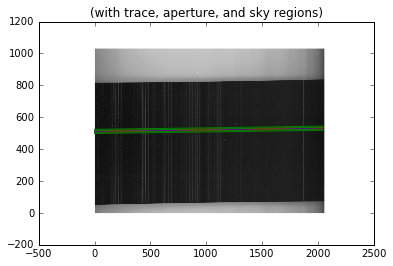

In [54]:
xbins = np.arange(data.shape[1])
apwidth=5
skysep=1
skywidth=7
skydeg=0

plt.figure()
plt.imshow(np.log10(data), origin='lower',aspect='auto',cmap=matplotlib.cm.Greys_r)

# the trace
plt.plot(xbins, trace,'b',lw=1)

# the aperture
plt.plot(xbins, trace-apwidth,'r',lw=1)
plt.plot(xbins, trace+apwidth,'r',lw=1)

# the sky regions
plt.plot(xbins, trace-apwidth-skysep,'g',lw=1)
plt.plot(xbins, trace-apwidth-skysep-skywidth,'g',lw=1)
plt.plot(xbins, trace+apwidth+skysep,'g',lw=1)
plt.plot(xbins, trace+apwidth+skysep+skywidth,'g',lw=1)

plt.title('(with trace, aperture, and sky regions)')
plt.show()

In [55]:
# map the wavelength using the HeNeAr fit
wfinal = pydis.mapwavelength(trace, wfit, mode='poly')
wfinalstd = pydis.mapwavelength(stdtrace, wfit, mode='poly')

In [56]:
# correct the object and flux std for airmass extinction
flux_red_x = pydis.AirmassCor(wfinal, flux_red, airmass,
                                airmass_file='apoextinct.dat')
flux_std_x = pydis.AirmassCor(wfinalstd, flux_std, stdairmass,
                                airmass_file='apoextinct.dat')

> Loading airmass library file: apoextinct.dat
> Loading airmass library file: apoextinct.dat


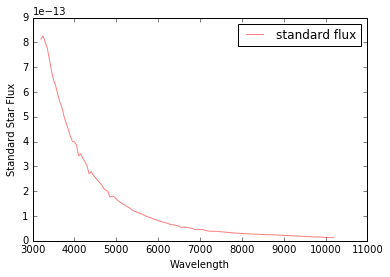

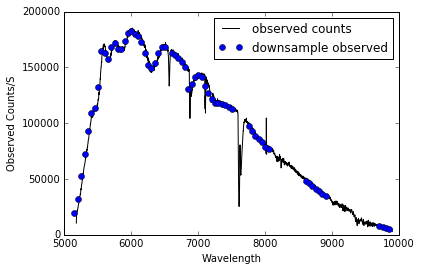

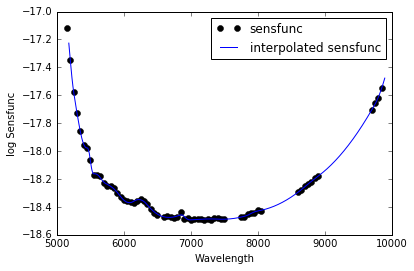

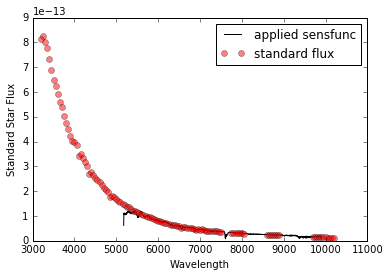

In [58]:
sensfunc = pydis.DefFluxCal(wfinalstd, flux_std_x, mode='spline',
                            stdstar='spec50cal/feige34.dat',display=True)

In [59]:
# final step in reduction, apply sensfunc
ffinal,efinal = pydis.ApplyFluxCal(wfinal, flux_red_x, fluxerr, 
                                    wfinalstd, sensfunc)

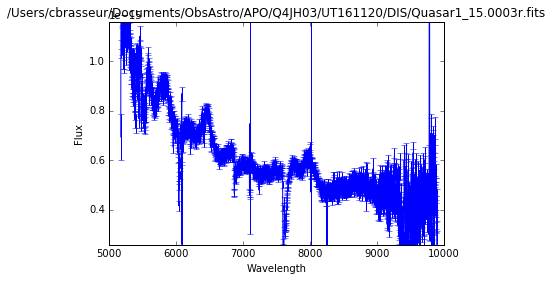

In [60]:
plt.figure()
# plt.plot(wfinal, ffinal)
plt.errorbar(wfinal, ffinal, yerr=efinal)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(spec)
#plot within percentile limits
plt.ylim( (np.percentile(ffinal,2),
           np.percentile(ffinal,98)) )
plt.show()

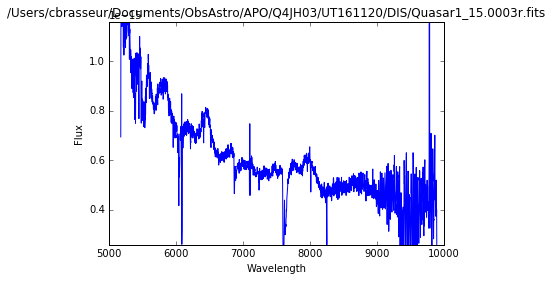

In [61]:
plt.figure()
# plt.plot(wfinal, ffinal)
plt.plot(wfinal, ffinal, '-')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(spec)
#plot within percentile limits
plt.ylim( (np.percentile(ffinal,2),
           np.percentile(ffinal,98)) )
plt.show()

In [67]:
# Saving the calebrated spectrum
wavelengthCol = fits.Column(name='Wavelength', format='D', array=wfinal)
fluxCol = fits.Column(name='Flux', format='D', array=wfinal)
errorCol = fits.Column(name='Flux Error', format='D', array=wfinal)

cols = fits.ColDefs([wavelengthCol,fluxCol,errorCol])

tbhdu = fits.BinTableHDU.from_columns(cols)

tbhdu.writeto(disDir + 'Quasar1_15.0003r_CALSPEC.fits')

array([  4.77841473e-17,   6.53655046e-17,   8.37296226e-17, ...,
         1.15710523e-16,   1.23684107e-16,   9.23563214e-17])